In [87]:
#!pip install yfinance
#!pip install hmmlearn
#pip install scipy
#pip install --upgrade --user hmmlearn
#pip install --user git+https://github.com/hmmlearn/hmmlearn
from sklearn.mixture import GaussianMixture
import yfinance as yf
import numpy as np
from numpy import random
import pandas as pd
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
import hmmlearn as hmm
from hmmlearn.hmm import GaussianHMM 
import matplotlib.pyplot as plt

# Data collection

In [88]:
ticker = "^GSPC"  #S&P 500 index symbol
data = yf.download(ticker, start="1950-03-01", end="2024-01-11", interval="1d")

data['Date'] = data.index
data.loc[(data['Open'] == 0) & (data.index >= '1961-12-29') & (data.index <= '1982-04-20'), 'Open'] = np.nan
data = data.round(2)

data.to_csv('data.csv', sep=';')

#Before 29th Dec 1961, same values in the row
#Between 29th Dec 1961 and 20th April 1982, "Open" set to 0

[*********************100%%**********************]  1 of 1 completed

c:\Users\graci\anaconda3\Lib\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [89]:
data_monthly = data.resample('MS', on='Date').mean()   #Monthly averages on the 1st of the month
data_monthly = data_monthly.round(2)

# Descriptive statistics

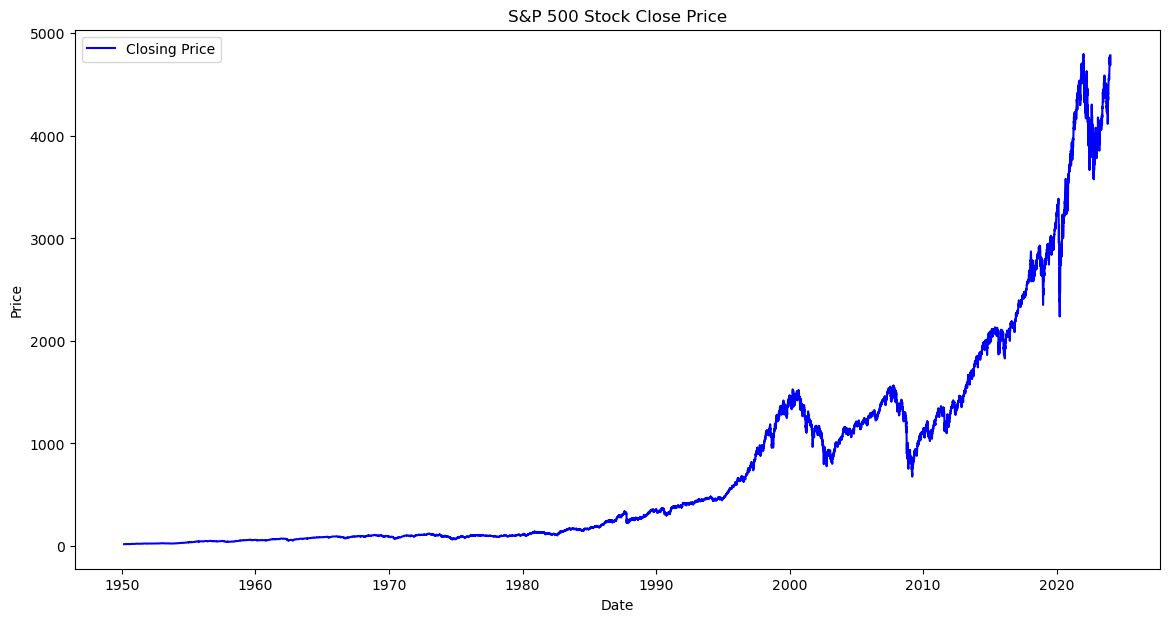

In [90]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Closing Price', color='blue')
plt.title('S&P 500 Stock Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [91]:
descriptive_stats = {
    "Price": ["Open", "High", "Low", "Close"],
    "Min": [data_monthly['Open'].min(), data_monthly['High'].min(), data_monthly['Low'].min(), data_monthly['Close'].min()],
    "Max": [data_monthly['Open'].max(), data_monthly['High'].max(), data_monthly['Low'].max(), data_monthly['Close'].max()],
    "Mean": [data_monthly['Open'].mean(), data_monthly['High'].mean(), data_monthly['Low'].mean(), data_monthly['Close'].mean()],
    "Std.": [data_monthly['Open'].std(), data_monthly['High'].std(), data_monthly['Low'].std(), data_monthly['Close'].std()],
}

summary_table = pd.DataFrame(descriptive_stats)
summary_table = summary_table.round(2)
summary_table.to_csv('summary_table.csv', index=False, sep=';')
summary_table

,Price,Min,Max,Mean,Std.
0,Open,17.35,4723.40,1040.17,1129.51
1,High,17.35,4750.39,794.49,1060.31
2,Low,17.35,4711.20,784.81,1048.04
3,Close,17.35,4733.86,789.96,1054.56


# Model Selection

In [94]:
#Method 1 : visual choice
sample = data_monthly.reset_index()
sample = sample[sample.columns[1:5]]
obs = sample[561:801]

# Set the number of observations to consider for each iteration
T = 120

AIC, BIC, HQC, CAIC = [], [], [], []

# Iterate over different number of components for the HMM model
for n in range(2, 7):
    np.random.seed(42)
    # Initialize empty lists to store the evaluation criteria values for each iteration
    a, b, c, d = [], [], [], []

    # Flag to check if it is the first iteration
    first_time = True

    # Iterate over the data with a sliding window of size T
    for i in range(0, T):
        # Define the HMM model
        if first_time:
            # For the first iteration, create a new model
            model = GaussianHMM(n_components=n, n_iter=T)
            first_time = False
        else:
            # For subsequent iterations, create a new model and initialize its parameters
            old_model = model
            model = GaussianHMM(n_components=n, init_params="c", n_iter=T)
            model.startprob_ = old_model.startprob_
            model.transmat_ = old_model.transmat_
            model.means_ = old_model.means_

        # Train the model using the Baum-Welch algorithm
        model.fit(obs[i:i+T])

        # Perform the forward algorithm to compute log-likelihoods and forward probabilities
        log_likelihoods, fwd = model.score_samples(obs[i:i+T])

        # Calculate the number of parameters for the model
        k = n**2 + 2*n - 1

        # Calculate AIC (Akaike Information Criterion)
        aic = -2 * log_likelihoods + 2 * k

        # Calculate BIC (Bayesian Information Criterion)
        bic = -2 * log_likelihoods + k * np.log(4 * T)

        # Calculate HQC (Hannan-Quinn Criterion)
        hqc = -2 * log_likelihoods + k * (np.log(np.log(4 * T)))

        # Calculate CAIC (Consistent Akaike Information Criterion)
        caic = -2 * log_likelihoods + k * (np.log(4 * T) + 1)

        # Append the evaluation criteria values to the corresponding lists
        a.append(aic)
        b.append(bic)
        c.append(hqc)
        d.append(caic)

    # Append the evaluation criteria lists for the current number of components to the main lists
    AIC.append(a)
    BIC.append(b)
    HQC.append(c)
    CAIC.append(d)

c:\Users\graci\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\graci\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\graci\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\graci\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

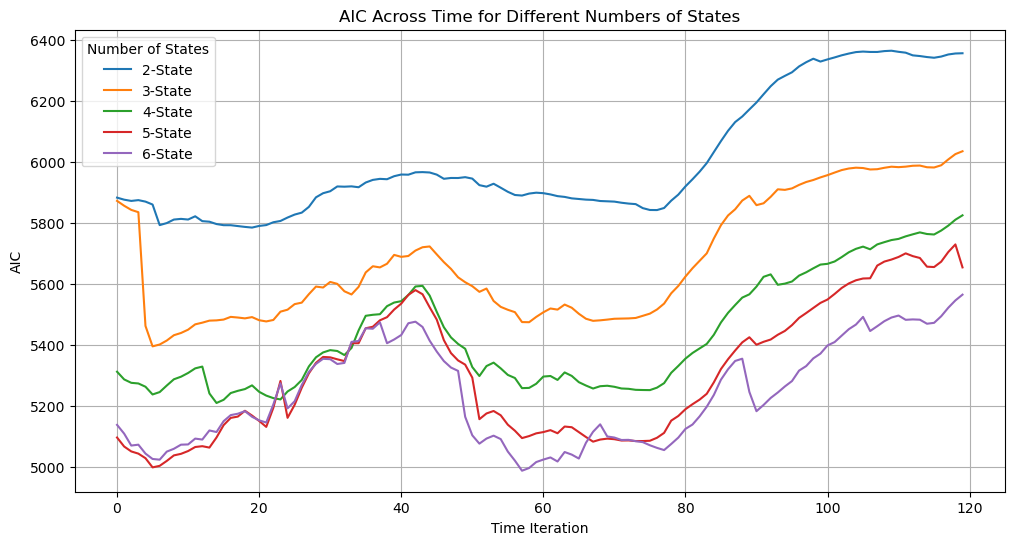

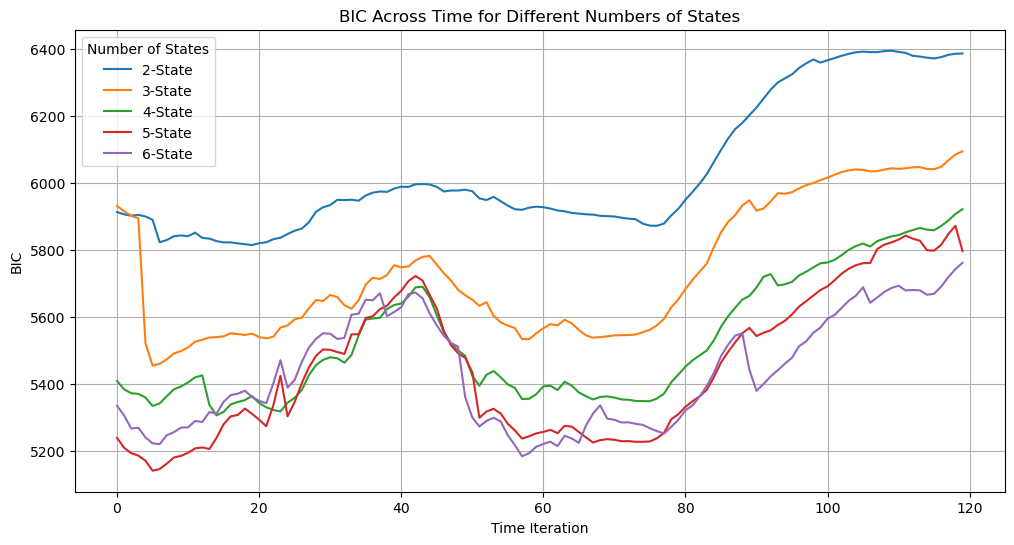

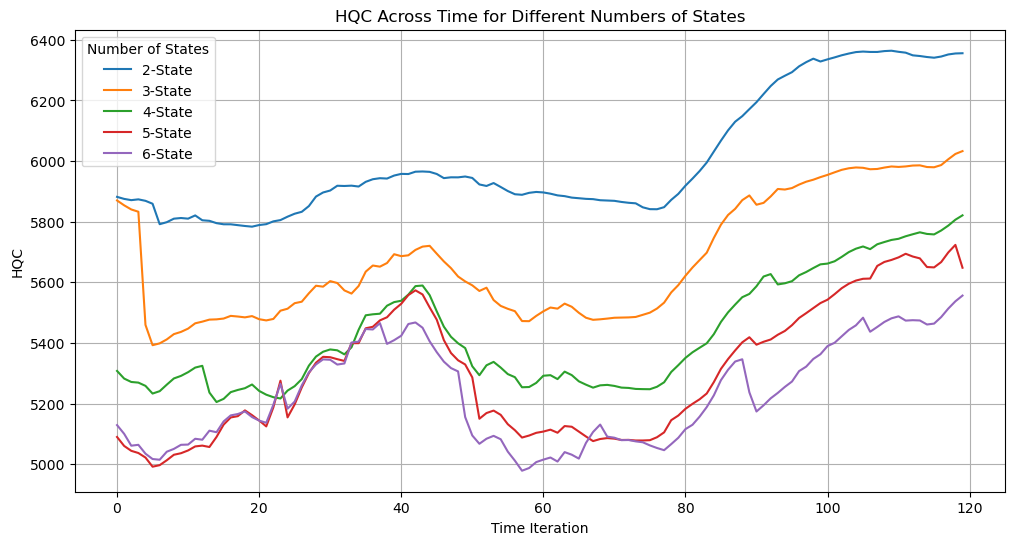

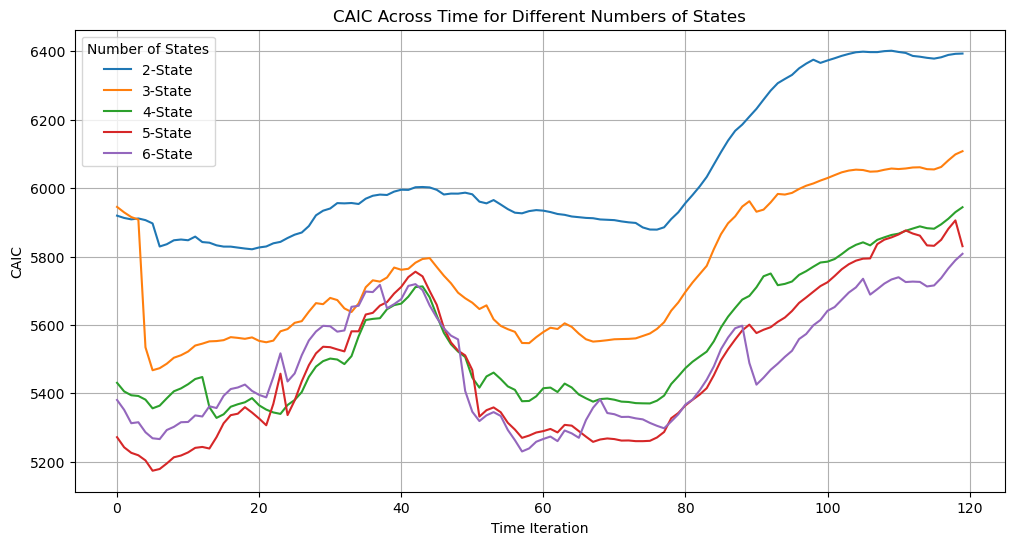

In [95]:
#Plot AIC values for different numbers of components
plt.figure(figsize=(12, 6))
for i in range(0, 5):
    plt.plot(AIC[i], label=f"{i+2}-State")
plt.title("AIC Across Time for Different Numbers of States")
plt.ylabel("AIC")
plt.xlabel("Time Iteration")
plt.grid(True)
plt.legend(title="Number of States")
plt.savefig("AIC_plot.png", format='png', dpi=300)  # Save as PNG
plt.show()

#Plot BIC 
plt.figure(figsize=(12, 6))
for i in range(0, 5):
    plt.plot(BIC[i], label=f"{i+2}-State")
plt.title("BIC Across Time for Different Numbers of States")
plt.xlabel("Time Iteration")
plt.ylabel("BIC")
plt.grid(True)
plt.legend(title="Number of States")
plt.savefig("BIC_plot.png", format='png', dpi=300)  
plt.show()

#Plot HQC 
plt.figure(figsize=(12, 6))
for i in range(0, 5):
    plt.plot(HQC[i], label=f"{i+2}-State")
plt.title("HQC Across Time for Different Numbers of States")
plt.xlabel("Time Iteration")
plt.ylabel("HQC")
plt.grid(True)
plt.legend(title="Number of States")
plt.savefig("HQC_plot.png", format='png', dpi=300) 
plt.show()

#Plot CAIC 
plt.figure(figsize=(12, 6))
for i in range(0, 5):
    plt.plot(CAIC[i], label=f"{i+2}-State")
plt.title("CAIC Across Time for Different Numbers of States")
plt.xlabel("Time Iteration")
plt.ylabel("CAIC")
plt.grid(True)
plt.legend(title="Number of States")
plt.savefig("CAIC_plot.png", format='png', dpi=300)  
plt.show()

In [85]:
#Method 2 : algoritmic choice 
#we are using the same obs as before
state_range = range(2, 7) 
best_model = None
best_criteria = {"AIC": float('inf'), "BIC": float('inf'), "HQC": float('inf'), "CAIC": float('inf')}
data_length = len(obs)
T=120

def calculate_model_criteria(hmm_model, M, k):                  #M as number of observations, k as number of parameters 
    L = hmm_model.score(obs)                                    #Use the correct model passed as the argument
    aic = -2 * L + 2 * k
    bic = -2 * L + k * np.log(M)
    hqc = -2 * L + 2 * k * np.log(np.log(M))
    caic = -2 * L + k * (1 + np.log(M))
    return {"AIC": aic, "BIC": bic, "HQC": hqc, "CAIC": caic}
 
for num_states in state_range:
    model = GaussianHMM(n_components=num_states, covariance_type='diag', random_state=42)
    model.fit(obs)

    # Number of parameters: Transition, emission, and initial probabilities
    num_params = num_states ** 2 + 2 * num_states - 1
    
    # Calculate evaluation criteria
    criteria = calculate_model_criteria(model, data_length, num_params)
    
    # Update best model based on BIC as the primary criterion
    if criteria["BIC"] < best_criteria["BIC"]:
        best_model = model
        best_criteria = criteria

print("Best Model Criteria:", best_criteria)
print(num_params)
print(num_states)

c:\Users\graci\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\graci\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\graci\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\graci\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

Best Model Criteria: {'AIC': 13221.63286587957, 'BIC': 13385.222895276644, 'HQC': 13287.547704364919, 'CAIC': 13432.222895276644}
47
6


# Prediction using HMM

In [ ]:
T = data_monthly.shape[0]
d = 120
D = 120
predicted_price = []

temp_T = T
first_time = True
;,;
# Sliding window approach to predict future prices
while T < temp_T + d:
    # Train HMM on data from T-D+1 to T
    train_data = obs.iloc[T-D:T]
    train_data = train_data.dropna()
    np.random.seed(42)

    if(first_time):
      first_time = False
      model = GaussianHMM(n_components=6)
    else:
      old_model= model
      model = GaussianHMM(n_components=6, init_params="c")
      model.startprob_ = old_model.startprob_
      model.transmat_ = old_model.transmat_
      model.means_ = old_model.means_

    model.fit(train_data)

    # Calculate original likelihood
    original_likelihood = model.score(train_data)

    # Loop to find new likelihood
    t=T
    min_diff = float('inf')
    min_t = T
    min_likelihood = original_likelihood
    while t-D>  0:
        t = t-1

        train_data = obs.iloc[t-D:t]
        train_data = train_data.dropna()
        new_likelihood = model.score(train_data)
        if (abs(new_likelihood - original_likelihood))< min_diff:  # Threshold for comparison by choosing that new_likelihood which is minimum
            min_diff = abs(new_likelihood - original_likelihood)
            min_t = t
            min_likelihood = new_likelihood

    # Calculate the predicted close price
    close_price = obs['Close'][T-1] + ((obs['Close'][min_t + 1] - obs['Close'][min_t]) * np.sign(original_likelihood - min_likelihood))
    predicted_price.append(close_price)
    T=T+1

# Print the calculated prices
print("HMM Prices: ")
print(predicted_price)

# Plot the predicted and observed prices
close = []
truncated_obs = sample.iloc[T-d:T]

for i in truncated_obs['Close']:
  close.append(i)

plt.plot(predicted_price,marker='.', label = "Predicted Price")
plt.plot(close,marker = '.', label= "Observed Price")
plt.ylabel("Close Price")
plt.legend()
plt.show()

ValueError: Found array with 0 sample(s) (shape=(0, 4)) while a minimum of 1 is required.

In [16]:
# Step 7: Evaluate predictions
predicted_prices = []

# For every observation, calculate the predicted price based on the best model
for i in range(len(obs1)):
    state = best_model.predict(obs1[:i + 1])[-1]  # Predict current state
    state_means = best_model.means_[state]  # Mean of observed values in the predicted state
    predicted_price = obs1.iloc[i] * (1 + state_means[-1])
    predicted_price = predicted_price.round(2)  # Predict price based on % change
    predicted_prices.append(predicted_price)


predicted_df = pd.DataFrame(predicted_prices)

# Make sure the index is a datetime index (if it's not already)
predicted_df.index = pd.to_datetime(predicted_df.index)

# Display the table
predicted_df

,Open,High,Low,Close
1996-12-02,676747.99,676756.93,671804.37,676336.76
1996-12-03,676336.76,680976.43,668308.97,668934.75
1996-12-04,668934.75,669042.02,660156.03,666091.95
1996-12-05,666091.95,668371.55,663865.98,665448.29
1996-12-06,665448.29,665448.29,649812.88,661175.15
...,...,...,...,...
2016-10-26,4281338.97,4298889.30,4270560.34,4286267.49
2016-10-27,4295543.52,4301694.15,4272423.56,4273465.36
2016-10-28,4271842.56,4288851.95,4246058.00,4260182.41
2016-10-31,4266934.08,4273886.09,4258419.36,4259661.51


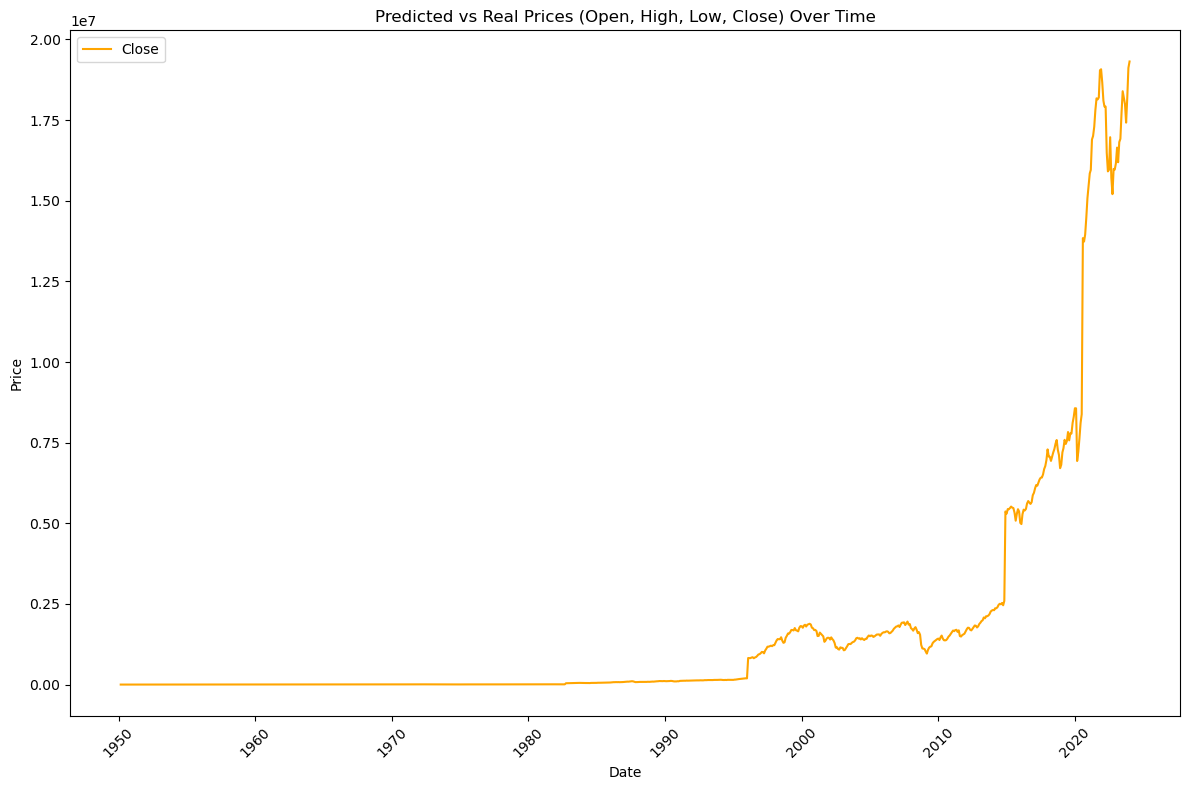

In [203]:
plt.figure(figsize=(12, 8))

plt.plot(predicted_df.index, predicted_df['Close'], label='Close', color='orange')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Predicted vs Real Prices (Open, High, Low, Close) Over Time')

# Display legend
plt.legend()

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

# Performance Evaluation

In [ ]:
# do R2, RMSE, and confusion matrix?
data['Predicted_Close'] = predicted_prices
data['HAR_Close'] = har_model
data.dropna(inplace=True)

hmm_mse = mean_squared_error(data['Close'], data['Predicted_Close'])
har_mse = mean_squared_error(data['Close'], data['HAR_Close'])
print(f"HMM MSE: {hmm_mse}, HAR MSE: {har_mse}")

In [ ]:
# Step 8: Trading simulation (buy if predicted rise, sell otherwise)
data['Signal'] = np.where(data['Predicted'] > obs, 1, -1)
data['Return'] = data['Signal'] * obs.pct_change()

hmm_cumulative_return = (1 + data['Return']).cumprod()
buy_and_hold_return = (1 + obs.pct_change()).cumprod()

# Print results
print(f"HMM Cumulative Return: {hmm_cumulative_return.iloc[-1]:.2f}")
print(f"Buy-and-Hold Cumulative Return: {buy_and_hold_return.iloc[-1]:.2f}")

## failed tries idk